<a href="https://colab.research.google.com/github/znah/lucid/blob/master/notebooks/differentiable-parameterizations/appendix/infinite_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infinite patterns by Alexander Mordvintsev


with &nbsp; <img src="https://artsandculture.withgoogle.com/naturalhistorymuseum/images/logo-black.svg" alt="drawing" width="200" style="margin-top:-10px;"/>
<p>&nbsp;</p>

![alt text](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/deepdream.png)

Google’s **Alexander Mordvintsev** is the creator of DeepDream, a computer vision program that uses a neural network to find and create patterns in images. The end result often leads to dream-like, hallucinogenic, hyper-processed images.

## Available to everyone

The idea for Infinite Patterns came from a trip to the [Google Arts & Culture Lab](https://experiments.withgoogle.com/collection/arts-culture) in Paris, where [Pinar&Viola](https://www.pinar-viola.com/) saw images created by [DeepDream](https://en.wikipedia.org/wiki/DeepDream) first hand – and noticed similarities between the neural network’s creations and their own body of work. Noticing an opportunity for collaboration, “it felt as if all we have ever done in our career was done to bring us here,” said the artists.

In December 2018, Pinar&Viola joined the lab as artists-in-residence, where they were able to work with Alex in the creation of new work. **Alex created a tool for the artists**, allowing them to create infinite patterns with DeepDream. First, the artists curated a selection of pictures, which were fed into the neural nets tool to extract inspiring patterns. Next, they combined these ML patterns with the original images to create the final design.

**Today, the tool made by Alexander is available for you to use in the creation of your own art works!**

This tools can create a patern from any picture. More info about how the algorythms works [here](https://distill.pub/2018/differentiable-parameterizations/). 

# Instructions

1.   Click **CONNECT** in the top right corner

![Connect](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/inst2.png)

2. Run the cells by clicking the play button on the top left corner

![Run cell](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/run-cell-2.png)

3.   Right click on the image to save it

![Save](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/save.jpg)


# Upload an image


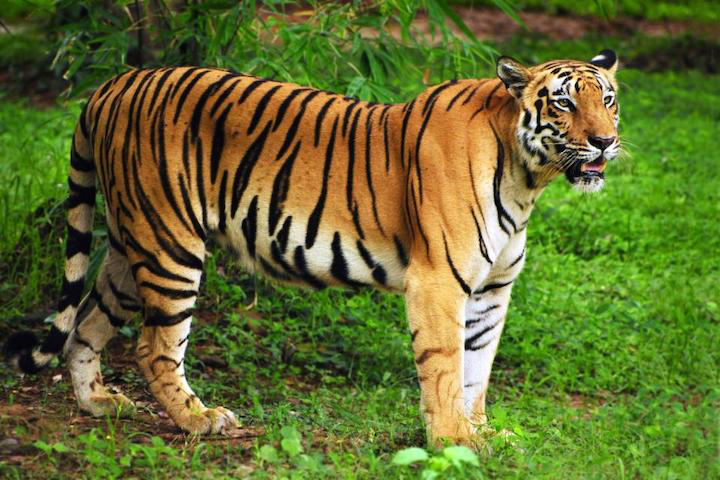

image uploaded, size: (720, 480)

In [0]:
#@title ← Click this button to upload a different image

try:
  import lucid
except ImportError:
  !pip install -q lucid

from __future__ import print_function
import os
import io
import string
import numpy as np
import PIL
import base64
from glob import glob

import matplotlib.pylab as pl

import tensorflow as tf
from tensorflow.contrib import slim

import IPython
from IPython.display import clear_output, Image, display, HTML

#import moviepy.editor as mpy
#from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

from google.colab import files
from google.colab import output
from google.colab import drive

from lucid.modelzoo import vision_models
import lucid.misc.io.showing as show
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session
from lucid.optvis import style
from lucid.modelzoo.util import forget_xy


def imwrite(fn, img):
  if len(img.shape) == 4:
    img = img[0]
  img = np.uint8(img.clip(0, 1)*255)
  im = PIL.Image.fromarray(img)
  im.save(fn, quality=95)


def anorm(a, axis=None, keepdims=False):
  return (a*a).sum(axis=axis, keepdims=keepdims)**0.5


def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    offset=0.0,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  coord_range = tf.to_float(tf.range(size))/tf.to_float(size)*2.0*np.pi
  #coord_range = tf.linspace(-np.pi, np.pi, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension
  net += offset
  net = tf.concat([tf.sin(net), tf.cos(net)], -1)
  

  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)
      
    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb



def render_graph(fn, size=224, stripe_width=256):
  graph_def = tf.GraphDef.FromString(open(fn, 'rb').read())
  g = tf.Graph()
  with g.as_default():
    tf.import_graph_def(graph_def, name='')
  with tf.Session(graph=g) as sess:
    ty, tx = 'meshgrid/mul:0', 'meshgrid/mul_1:0'
    y, x = sess.run([ty, tx], {'size:0': size})
    stripes = []
    for s in range(0, len(x), stripe_width):
      stripe = sess.run('image:0', 
                     {tx: x[s:s+stripe_width], ty: y[s:s+stripe_width]})
      stripes.append(stripe[0])
  return np.vstack(stripes)


model = vision_models.InceptionV1_caffe()
model.load_graphdef()

print('\n↓ Now click the "Choose Files" button and select an image\n')

from google.colab import files
uploaded = files.upload()
image_name, _ = uploaded.popitem()

clear_output()

im = PIL.Image.open(image_name)
g_image = np.float32(im)[...,:3]/255.0
show.image(g_image)

print('\rimage uploaded, size:', im.size, end='')

# Render patterns


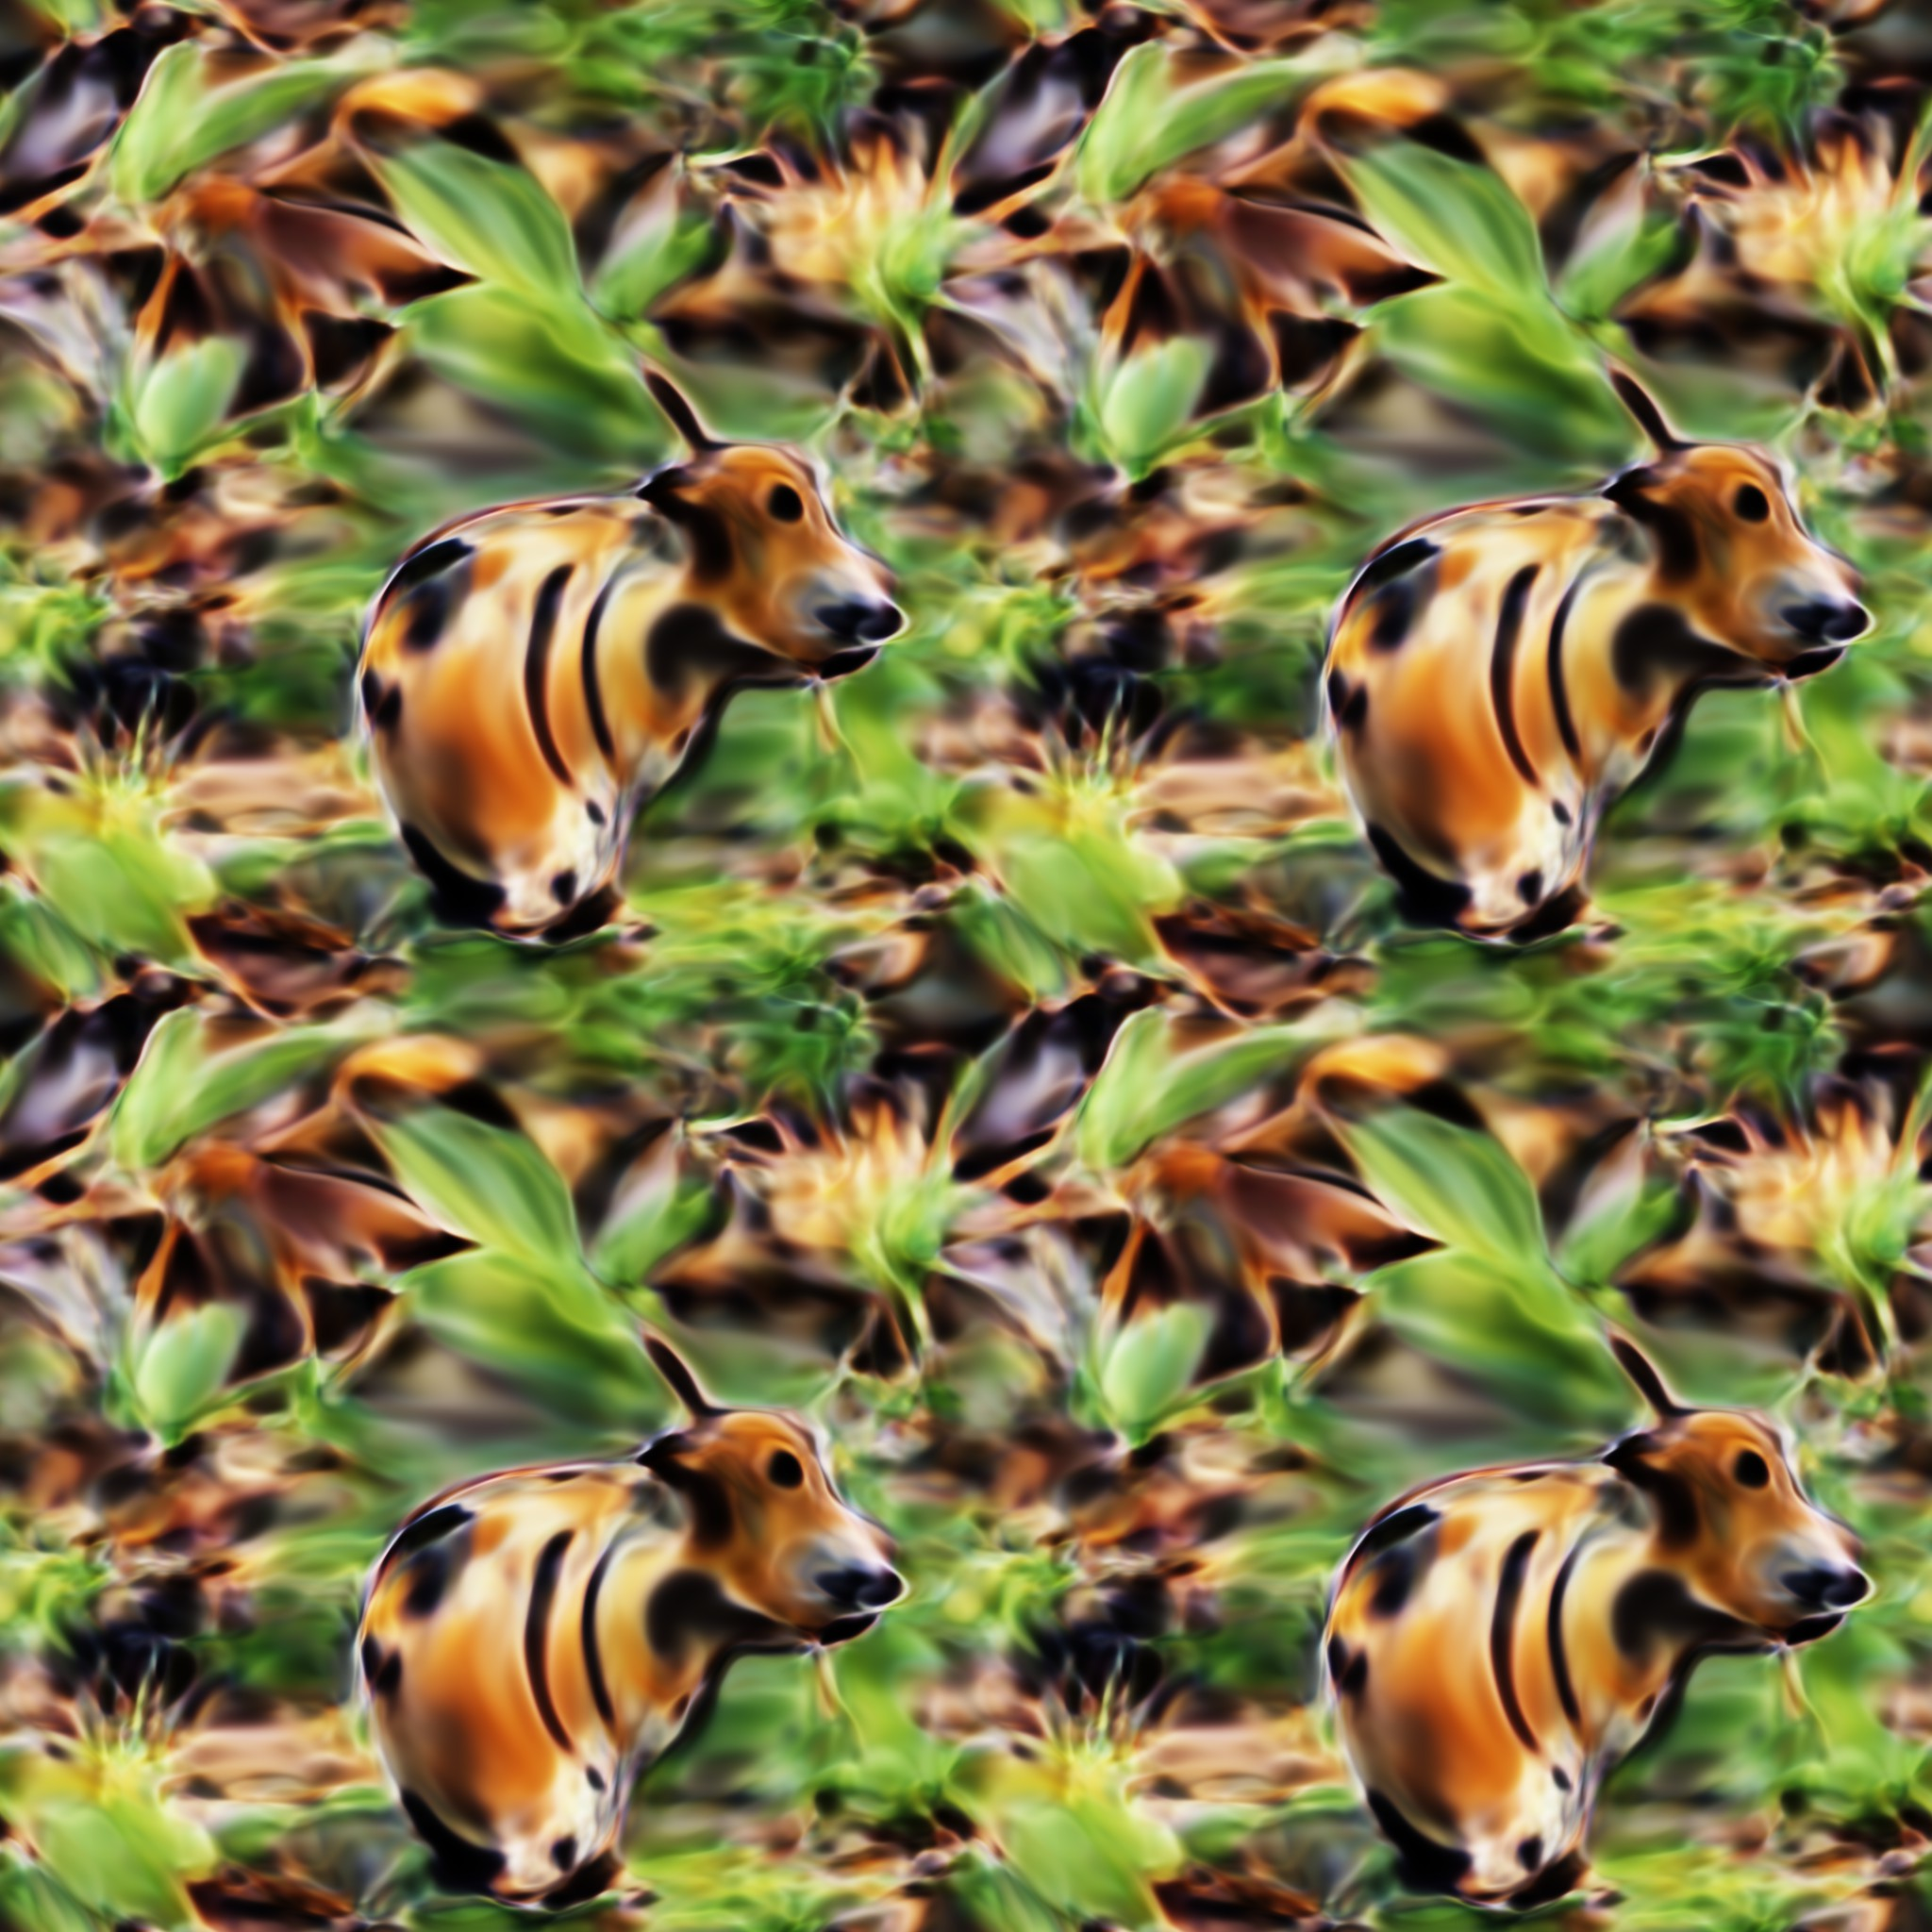

In [0]:
#@title ← Click this button to render
#@markdown &nbsp;

objective = 'v2' #@param ['v1', 'v2']
activation = 'composite' #@param ['composite', 'relu']
style_weight = 1.34 #@param {type: "slider", min: 0.0, max: 2.0, step:0.01}
layer_index = 7 #@param {type: "slider", min: 2, max: 8}


sess = create_session()

t_size = tf.placeholder_with_default(224, [], name='size')
t_offset = tf.placeholder_with_default([0.0, 0.0], [2], name='offset')
if activation == 'relu':
  t_image = image_cppn(t_size, normalize=True, activation_fn=tf.nn.relu)
elif activation == 'composite':
  t_image = image_cppn(t_size, t_offset, normalize=False, activation_fn=composite_activation_unbiased)
t_image = forget_xy(t_image)
t_image = tf.identity(t_image, 'image')

model.import_graph(t_image)

tensor_name = 'import/%s:0'%model.layers[layer_index].name
tensor = sess.graph.get_tensor_by_name(tensor_name)
act = sess.run(tensor_name, {t_image:g_image[None, :,:,:3]})

if objective=='v2':
  act = act.reshape(-1, act.shape[-1])
  act /= anorm(act, -1, True)

  flat_tensor = tf.reshape(tensor, [-1, act.shape[-1]])
  flat_tensor /= tf.norm(flat_tensor, axis=-1, keepdims=True)

  cross = tf.matmul(flat_tensor, act, transpose_b=True)
  t_loss0 = -tf.reduce_mean(tf.reduce_max(cross, 0))
  t_loss1 = -tf.reduce_mean(tf.reduce_max(cross, 1))
  t_loss = t_loss0 + t_loss1 - tf.reduce_mean(tensor)*0.05
else:
  target_act = act.mean((0, 1, 2))
  t_dd_loss = -tf.reduce_mean(tensor*target_act)
  sl = style.StyleLoss([tensor], loss_func=style.mean_l1_loss)
  t_loss = t_dd_loss + sl.style_loss*style_weight

t_lr = tf.constant(0.003)
trainer = tf.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(t_loss)

init_op = tf.global_variables_initializer()
init_op.run()
if objective=='v1':
  sl.set_style({t_image:g_image[None,...]})

init_op.run()
try:
  for i in range(500+1):
    dx, dy = np.random.rand(2)*np.pi*2
    _, loss = sess.run([train_op, t_loss], {t_offset:[dx, dy]})
    if i%50 == 0:
      clear_output()
      show.image(sess.run(t_image), format='jpeg')
      print(i, loss)
except KeyboardInterrupt:
  pass

img = sess.run(t_image, {t_size:1024})
large_img = np.tile(img, [2, 2, 1])

clear_output()
show.image(large_img, format='jpeg')